tgb - 12/4/2019 - Preparing Figures and Movies for AGU 2019

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

[Errno 2] No such file or directory: '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM'
/data11/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


# 1) Movie of convective heating and moistening from JNNL

In [32]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}
NNarray = ['JNNL']

In [33]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[i])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [34]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(90,120)

In [81]:
lat_ind = np.arange(0,64)
iini = 1000
iend = 1100

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate([NNarray[0]]):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                if field=='PHQ': ind_field = PHQ_idx
                elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

In [26]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [61]:
lev

<xarray.DataArray 'lev' (lev: 30)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  38.2683  ,  54.59548 ,
        72.012451,  87.82123 , 103.317127, 121.547241, 142.994039, 168.22508 ,
       197.908087, 232.828619, 273.910817, 322.241902, 379.100904, 445.992574,
       524.687175, 609.778695, 691.38943 , 763.404481, 820.858369, 859.534767,
       887.020249, 912.644547, 936.198398, 957.48548 , 976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [65]:
np.mean(np.abs(diagno['truth']['PHQ']-diagno[NNs]['PHQ']),axis=(0,1,3))/np.mean(diagno['truth']['PHQ'])

array([-2.21732855e-01, -4.90605086e-01, -7.93605596e-02, -3.83866057e-02,
       -2.99818423e-02, -8.67431760e-02, -3.33269238e-02, -5.98317623e-01,
       -5.92359565e-02, -1.36215091e-01, -4.10173833e-01, -1.17469513e+00,
       -2.76867390e+00, -5.19640541e+00, -8.83940506e+00, -1.46848135e+01,
       -2.44030914e+01, -3.62294579e+01, -5.73021545e+01, -8.61061478e+01,
       -1.30888977e+02, -1.74015015e+02, -1.90143906e+02, -1.62064194e+02,
       -1.66486984e+02, -1.65547272e+02, -1.52508423e+02, -1.28829865e+02,
       -1.20462967e+02, -1.33965790e+02], dtype=float32)

In [66]:
np.mean(np.abs(diagno['truth']['TPHYSTND']-diagno[NNs]['TPHYSTND']),axis=(0,1,3))/np.mean(diagno['truth']['TPHYSTND'])

array([ -0.27433896,  -0.45259702,  -2.041872  ,  -2.075538  ,
        -0.53000975,  -0.46023196,  -0.6341023 ,  -0.81733567,
        -1.1199936 ,  -1.3175882 ,  -1.5396122 ,  -2.151741  ,
        -2.6071906 ,  -3.371945  ,  -4.145045  ,  -4.802201  ,
        -5.7795453 ,  -7.2278066 ,  -8.44115   , -10.198541  ,
       -13.095983  , -18.067905  , -20.79542   , -16.303675  ,
       -14.750556  , -12.650582  ,  -9.870063  ,  -7.5626197 ,
        -5.8910537 ,  -6.1236157 ], dtype=float32)

In [ ]:
diagno['truth']['PHQ'][:,:,-2,:].shape

In [74]:
# Plot characteristics
fz = 17.5
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

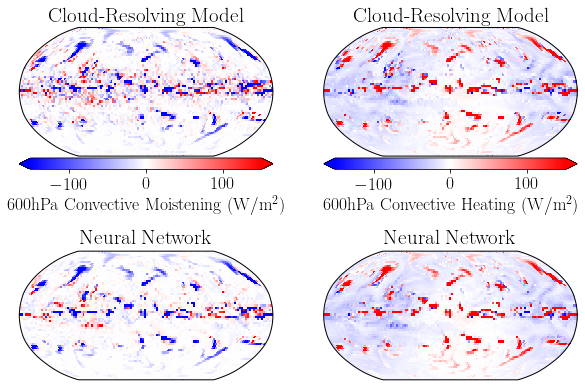

In [82]:
pathHOME = '/home/t/Tom.Beucler/Movie1/'
vminQ = -150
vmaxQ = 150
vminT = -150
vmaxT = 150
iz = -11 # -11 is 600hPa
it = 0

for it in range(100):

    plt.close('all')

    fig,ax = plt.subplots(2,2,figsize=(10,7.5),subplot_kw=dict(projection=ccrs.Robinson()))

    # (a) Convective Moistening
    im = ax[0,0].imshow(diagno['truth']['PHQ'][:,:,iz,it],cmap='bwr',vmin=vminQ,vmax=vmaxQ,transform=ccrs.PlateCarree())
    ax[0,0].set_title('Cloud-Resolving Model')
    cb = fig.colorbar(im, ax=ax[0,0], pad=0.01, extend='both', orientation='horizontal'); 
    cb.set_label('$\mathrm{600hPa\ Convective\ Moistening\ (W/m^{2})}$')

    # (b) Convective Heating
    im = ax[0,1].imshow(diagno['truth']['TPHYSTND'][:,:,iz,it],cmap='bwr',vmin=vminT,vmax=vmaxT,transform=ccrs.PlateCarree())
    ax[0,1].set_title('Cloud-Resolving Model')
    cb = fig.colorbar(im, ax=ax[0,1], pad=0.01, extend='both', orientation='horizontal'); 
    cb.set_label('$\mathrm{600hPa\ Convective\ Heating\ (W/m^{2})}$')

    # (a) Convective Moistening
    im = ax[1,0].imshow(diagno[NNs]['PHQ'][:,:,iz,it],cmap='bwr',vmin=vminQ,vmax=vmaxQ,transform=ccrs.PlateCarree())
    ax[1,0].set_title('Neural Network')
    #cb = fig.colorbar(im, ax=ax[1,0], pad=0.01, extend='both', orientation='horizontal'); 
    #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Moistening\ (W/m^{2})}$')

    # (b) Convective Heating
    im = ax[1,1].imshow(diagno[NNs]['TPHYSTND'][:,:,iz,it],cmap='bwr',vmin=vminT,vmax=vmaxT,transform=ccrs.PlateCarree())
    ax[1,1].set_title('Neural Network')
    #cb = fig.colorbar(im, ax=ax[1,1], pad=0.01, extend='both', orientation='horizontal'); 
    #cb.set_label('$\mathrm{PRED\ 600hPa\ Convective\ Heating\ (W/m^{2})}$')

    # matplotlib.pyplot.gcf().suptitle("Time to Crash: "+"%02.1f"%(cam_ds.time[-1]-cam_ds.time[it])+"day",
    #                                  fontsize=fz)
    plt.savefig(pathHOME+str(it)+'.png',format='png')

# 2) Dynamic Figure of trade-off between performance and constraints

## 2.1) Load data for Figure 3a

In [9]:
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
alpha_array = [0,0.01,0.25,0.5,0.75,0.99,1] # Loop over weight given to MSE and conservation constraints
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
fz = 20
lw = 4
siz = 200
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
MSEtp = {}; PENtp = {};

NN = {}; md = {};
NN = load_model(TRAINDIR+'HDF5_DATA/MLRL0.h5')
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/MLRL0md.pkl','rb'))
md.resid = pickle.load(open(TRAINDIR+'HDF5_DATA/MLRL0res.pkl','rb'))
MSEtp['MLRL0'] = np.log10(md.mse_W2m4().mean((0,1,2)))
PENtp['MLRL0'] = np.log10(0.25*(md.resid['mass']+md.resid['ent']+\
                                md.resid['sw']+md.resid['lw']).mean((0,1,2)))

for alpha in alpha_array:
    print('alpha = ',str(alpha))
    NN = {}; md = {};
    print('alpha = ',str(alpha))
    # 0) Define model/statistics to load
    config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
    dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
    # Path of model/statistics
    path_model = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'.h5'
    
    data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
    path_md = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'md.pkl'
    path_res = TRAINDIR+'HDF5_DATA/NNL'+str(alpha)+'res.pkl'

    # 1) Load model
    NN = load_model(path_model,custom_objects=dict_lay)

    # 2) Define and load md
    md = ModelDiagnostics(NN,config_fn,data_fn)
    md.stats = pickle.load(open(path_md,'rb'))

    # 3) Load res
    md.resid = pickle.load(open(path_res,'rb'))
    MSEtp[str(alpha)] = np.log10(md.mse_W2m4().mean((0,1,2)))
    PENALTY = 0.25*(md.resid['mass']+md.resid['ent']+\
                    md.resid['sw']+md.resid['lw']).mean((0,1,2))
    PENtp[str(alpha)] = np.log10(PENALTY)

NN = {}; md = {};
NN = load_model(TRAINDIR+'HDF5_DATA/JNNC.h5',custom_objects=dict_lay)
md = ModelDiagnostics(NN,config_fn,data_fn)
md.stats = pickle.load(open(TRAINDIR+'HDF5_DATA/JNNCmd.pkl','rb'))
md.resid = pickle.load(open(TRAINDIR+'HDF5_DATA/JNNCmdres.pkl','rb'))
MSEtp['NNA'] = np.log10(md.mse_W2m4().mean((0,1,2)))
PENtp['NNA'] = YMIN+0.1

W1205 07:59:39.216779 22412127254336 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1205 07:59:39.217673 22412127254336 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1205 07:59:39.218681 22412127254336 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

alpha =  0
alpha =  0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.01
alpha =  0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.25
alpha =  0.25


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.5
alpha =  0.5


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.75
alpha =  0.75


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  0.99
alpha =  0.99


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


alpha =  1
alpha =  1


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## 2.2) Dynamic Figure

In [8]:
pathHOME = '/home/t/Tom.Beucler/Figure1/'

0 $-1$
1 $0$
2 $1$
3 $2$
4 $3$
5 $4$


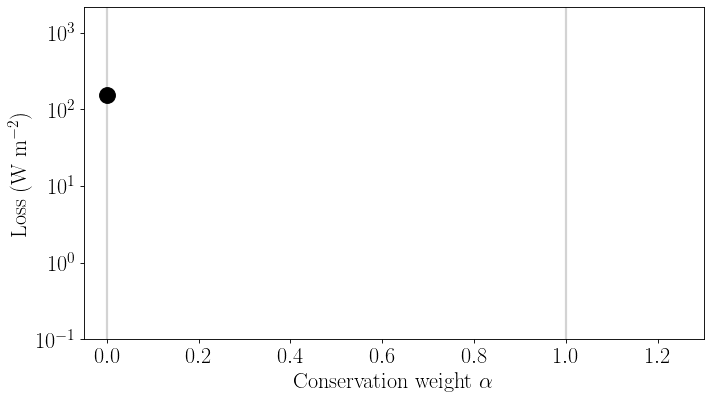

In [38]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

f = plt.figure(num=None, figsize=(10,5.5), dpi=80, facecolor='w', edgecolor='k')
#plt.gcf().subplots_adjust(bottom=0.15) # Make room for xlabels

### Subplot 1 ###

#ax = f.add_subplot(1,2,1)
MSEs = {}; PENs = {};

ax = f.gca()

plt.axvline(x=0,color='lightgray',linewidth=lw/2,zorder=0)
plt.axvline(x=1,color='lightgray',linewidth=lw/2,zorder=0)

STR = 'MLRL0'
#Hlin1 = plt.axhline(y=MSEtp[STR],c='k',linestyle='--',zorder=1)
#Hlin2 = plt.axhline(y=PENtp[STR],c='b',linestyle='--',zorder=1)

for alpha in [alpha_array[0]]:
    STR = str(alpha)
    MSEs[str(alpha)] = plt.scatter(alpha,MSEtp[STR],c='k',s=siz)
    #PENs[str(alpha)] = plt.scatter(alpha,PENtp[STR],c='b',s=siz)
    
for alpha in alpha_array:
    STR = str(alpha)
    #MSEs[str(alpha)] = plt.scatter(alpha,MSEtp[STR],c='k',s=siz)
    #PENs[str(alpha)] = plt.scatter(alpha,PENtp[STR],c='b',s=siz)

# STR = 'NNA'
# MSEs['NNA'] = plt.scatter(XNNA,MSEtp[STR],c='k',s=siz,marker='*')
# PENs['NNA'] = plt.scatter(XNNA,YMIN+0.2,c='b',s=3*siz,marker="$\downarrow$")
# MSEt = plt.text(XNNA-XTEXT,MSEtp[STR]-YTEXT-0.1,s='$\mathrm{ACnet}$',color='k')
# PENt = plt.text(XNNA-XTEXT,YMIN+0.1+YTEXT/2,s='$\mathrm{ACnet}$',color='b')
# PENu = plt.text(0,2.75,s='$\mathrm{UCnet}$',color='b')
    
plt.xlim((-0.05,1.3))
plt.ylim((YMIN,3.33))

plt.xlabel(r'$\mathrm{Conservation\ weight\ }\alpha$')
plt.ylabel(r'$\mathrm{Loss\ (W\ m^{-2})}$')

# Add LCnet legend
# plt.arrow(0.475, -0.925, -0.475, 0, color='lightgray', linewidth=lw/2)
# plt.arrow(0.725, -0.925, 0.275, 0, color='lightgray', linewidth=lw/2)
#PENu = plt.text(0.5,-0.925,s='$\mathrm{LCnet}$',color='gray')

plt.draw()
# Change y labels to 10^n
labels = [item.get_text() for item in ax.get_yticklabels()]
for ilab,lab in enumerate(labels):
    print(ilab,lab)
    labels[ilab]='$10^{'+lab[1:-1]+'}$'
ax.set_yticklabels(labels)
name = '0'
plt.savefig(pathHOME+name+'.png',format='png')

In [31]:
name = '5'

In [32]:
plt.savefig(pathHOME+name+'.png',format='png')

<Figure size 432x288 with 0 Axes>

# 3) SST generalization plot

tgb - 3/12/20 - Adding the (-4K) to (+4K) jump

In [39]:
data0K = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-06-01-00000.nc",\
                    decode_times=False)

In [2]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                          decode_times=False)

In [40]:
data4K = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.0000-06-01-00000.nc",\
                        decode_times=False)

In [3]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                           decode_times=False)

In [18]:
# Plot characteristics
fz = 20
lw = 4
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [6]:
SSTm4K = np.max(np.mean(datam4K.TS,axis=(0,2)))
ileft = np.argmin(np.abs(SSTm4K-np.mean(datap4K.TS,axis=(0,2))))
iright = np.argmin(np.abs(SSTm4K-np.mean(datap4K.TS,axis=(0,2))[(ileft.values+1):]))+ileft.values+1

In [7]:
# SSTmax0K = np.max(np.mean(data0K.TS,axis=(0,2)))
# ileft = np.argmin(np.abs(SSTmax0K-np.mean(data4K.TS,axis=(0,2))))
# iright = np.argmin(np.abs(SSTmax0K-np.mean(data4K.TS,axis=(0,2))[(ileft.values+1):]))+ileft.values+1

In [15]:
ileft = ileft.values
iright = iright.values

In [16]:
print(ileft,iright)

23 42


In [29]:
pathHOME = '/home/t/Tom.Beucler/'

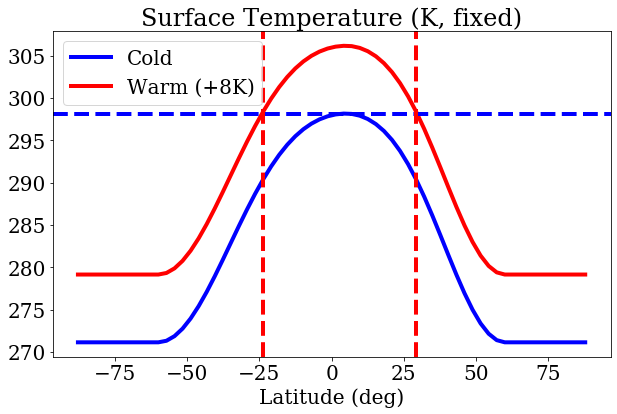

In [25]:
plt.figure(figsize=(10,6))
plt.plot(datam4K.lat,np.mean(datam4K.TS,axis=(0,2)),label='Cold',color='b')
plt.plot(datap4K.lat,np.mean(datap4K.TS,axis=(0,2)),label='Warm (+8K)',color='r')
plt.axhline(y=SSTm4K,color='b',linestyle='--')
plt.axvline(x=datap4K.lat[ileft],color='r',linestyle='--')
plt.axvline(x=datap4K.lat[iright],color='r',linestyle='--')
plt.legend()
plt.xlabel('Latitude (deg)')
#plt.ylabel('Surface temperature (K)')
plt.title('Surface Temperature (K, fixed)')
# plt.title('SST(ref) max='+'%02.1f'%SSTmax0K+'K intersects with lat(+4K)='+
#           '%02.0f'%datap4K.lat[ileft]+' and '+'%02.0f'%datap4K.lat[iright]+' deg')
name = 'SST0'
#plt.savefig(pathHOME+name+'.png',format='png')

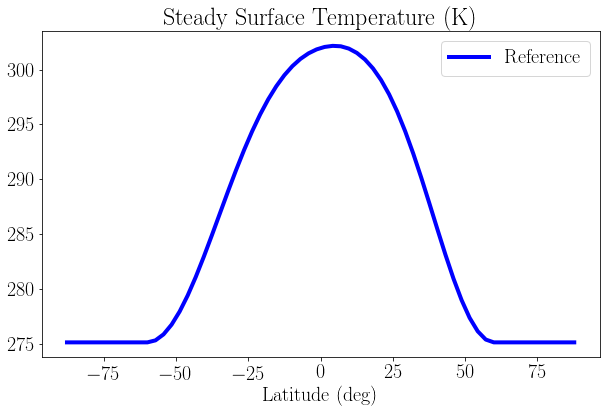

In [51]:
plt.figure(figsize=(10,6))
plt.plot(data0K.lat,np.mean(data0K.TS,axis=(0,2)),label='Reference',color='b')
# plt.plot(data4K.lat,np.mean(data4K.TS,axis=(0,2)),label='+4K',color='r')
# plt.axhline(y=SSTmax0K,color='b',linestyle='--')
# plt.axvline(x=data4K.lat[ileft],color='r',linestyle='--')
# plt.axvline(x=data4K.lat[iright],color='r',linestyle='--')
plt.legend()
plt.xlabel('Latitude (deg)')
#plt.ylabel('Surface temperature (K)')
plt.title('Steady Surface Temperature (K)')
# plt.title('SST(ref) max='+'%02.1f'%SSTmax0K+'K intersects with lat(+4K)='+
#           '%02.0f'%data4K.lat[ileft]+' and '+'%02.0f'%data4K.lat[iright]+' deg')
name = 'SST0'
plt.savefig(pathHOME+name+'.png',format='png')

# 4) Show mean bias in convective heating and moistening

In [88]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse,'MassConsLayer_choice': MassConsLayer_choice,\
            'EntConsLayer_choice': EntConsLayer_choice}
NNarray = ['JNNL','JNNL0.01','JNNC']
NNname = ['Unconstrained','Loss-constrained','Architecture-constrained']

In [91]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(90,120)

## 4.1) +0K

In [89]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[0])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [108]:
lat_ind = np.arange(26,40)
iini = 1000
iend = 1047

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                if field=='PHQ': ind_field = PHQ_idx
                elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

In [109]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [25]:
# Plot characteristics
fz = 20
lw = 4
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

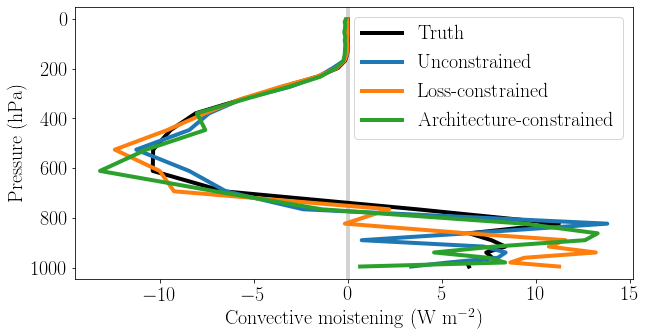

In [118]:
plt.figure(figsize=(10,5))

plt.axvline(x=0,c='lightgray')
plt.plot(np.mean(diagno['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
for iNN,NNs in enumerate(NNarray[0:3]):
    plt.plot(np.mean(diagno[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

name = 'CQ3'
plt.savefig(pathHOME+name+'.png',format='png')

## 4.2) +4K

In [119]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[2])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [120]:
lat_ind = np.arange(26,40)
iini = 1000
iend = 1047

diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                if field=='PHQ': ind_field = PHQ_idx
                elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

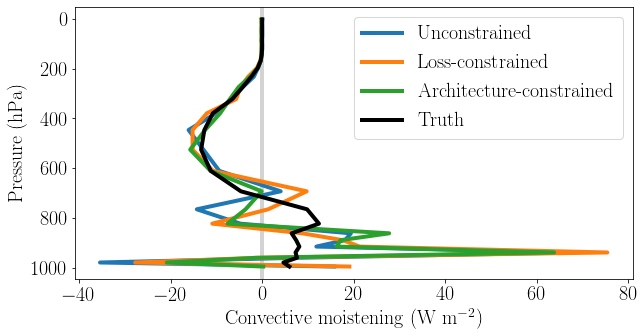

In [122]:
plt.figure(figsize=(10,5))

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:3]):
    plt.plot(np.mean(diagno[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()

name = 'CQ3p4'
plt.savefig(pathHOME+name+'.png',format='png')

# 5) Clausius-Clapeyron plot

In both simulations, bin near-surface specific humidity by near-surface temperature

In [53]:
hist0,bine0 = np.histogram(data0K.TAP[:,-1,:,:],bins=50)

In [54]:
hist4,bine4 = np.histogram(data4K.TAP[:,-1,:,:],bins=50)

In [55]:
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

In [57]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [64]:
qs0m,qs0std = conditional_avg_and_std(bine0,data0K.TAP[:,-1,:,:],data0K.QAP[:,-1,:,:])
T0m,T0std = conditional_avg_and_std(bine0,data0K.TAP[:,-1,:,:],data0K.TAP[:,-1,:,:])

In [67]:
qs4m,qs4std = conditional_avg_and_std(bine4,data4K.TAP[:,-1,:,:],data4K.QAP[:,-1,:,:])
T4m,T4std = conditional_avg_and_std(bine4,data4K.TAP[:,-1,:,:],data4K.TAP[:,-1,:,:])

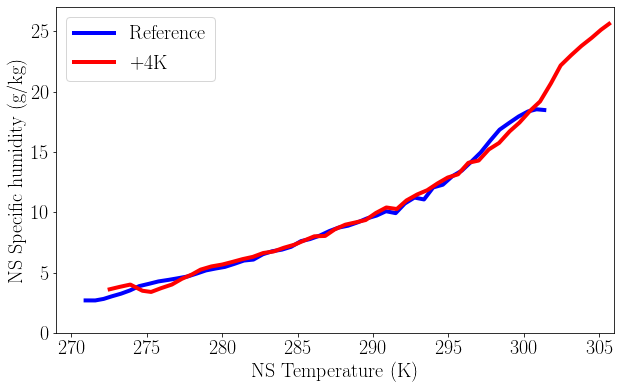

In [83]:
plt.figure(figsize=(10,6))

#plt.fill_between(T0m[:,0],1e3*(qs0m[:,0]-qs0std[:,0]),1e3*(qs0m[:,0]+qs0std[:,0]),color='lightblue')
#plt.fill_between(T4m[:,0],1e3*(qs4m[:,0]-qs4std[:,0]),1e3*(qs4m[:,0]+qs4std[:,0]),color='lightcoral')
plt.plot(T0m,1e3*qs0m,color='b',label='Reference')
plt.plot(T4m,1e3*qs4m,color='r',label='+4K')
plt.ylabel('NS Specific humidity (g/kg)')
plt.xlabel('NS Temperature (K)')
plt.legend()
plt.xlim((269,306))
plt.ylim((0,27))
name = 'CC1'
plt.savefig(pathHOME+name+'.png',format='png')

# 6) Two-stage improvements on convective heating and moistening

In [2]:
# Config and data files for POG experiment
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/101_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/148_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/151_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/101_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/148_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/151_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/102_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/149_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/152_valid.nc']
NNarray = ['POG101','POG104','POG148','POG151']
NNname = ['Brute Force','Relative Humidity','Flux','Eps']

In [3]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    #NN[NNs] = load_model(path,custom_objects=dict_lay)
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

W1208 18:02:40.714049 22602863609664 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1208 18:02:40.714720 22602863609664 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1208 18:02:40.715760 22602863609664 deprecation.py:506] From /home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG101


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG148


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG151


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [4]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [ ]:
lat_ind = np.arange(26,40)
iini = 500
iend = 644

for isim in range(2):
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate(NNarray):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
    if isim==0: diagno0 = diagno 
    elif isim==1: diagno4 = diagno

In [ ]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [ ]:
pathHOME = '/home/t/Tom.Beucler/'
# Plot characteristics
fz = 20
lw = 4
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [ ]:
diagno = diagno4

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-45,30))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth']['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
#plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-9,39))

name = 'G2'
plt.savefig(pathHOME+name+'.png',format='png')

# 7) Third stage improvement (output scaling)

## 7.1) Develop algorithm

In [ ]:
md = md0

In [ ]:
inp_norm104, p, truth = md['POG104'].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

In [ ]:
inp = inp_norm104*md['POG104'].valid_gen.input_transform.div+\
md['POG104'].valid_gen.input_transform.sub

In [ ]:
inp_norm148 = (inp-md['POG148'].valid_gen.input_transform.sub)/\
md['POG148'].valid_gen.input_transform.div

In [ ]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_12_03_SEF_fit.pkl','rb')
SFfit = pickle.load(hf)
lfit = SFfit['LHFlogfit']
sfit = SFfit['SHFfit']

In [ ]:
inp.shape

In [ ]:
x = np.log10(inp[:,30:60][:,-1])

In [ ]:
LHF = 10**(lfit[0]*x**0+lfit[1]*x**1+lfit[2]*x**2)
SHF = sfit
SEF = LHF+SHF

In [ ]:
pred148 = md['POG148'].model.predict_on_batch(inp_norm148)

In [ ]:
pred148[:,0:60] = pred148[:,0:60]*np.transpose(np.tile(SEF,(60,1)))/100

## 7.2) Use for comparison

In [ ]:
lat_ind = np.arange(26,40)
iini = 500
iend = 644

for isim in range(2):
    if isim==0: md = md0
    elif isim==1: md = md4
    dTHIRD = {} # dTHIRDstics structure
    for i,NNs in enumerate([NNarray[2]]):
        dTHIRD[NNs] = {} # dTHIRDstics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp_norm104, p, truth = md['POG104'].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            inp = inp_norm104*md['POG104'].valid_gen.input_transform.div+\
            md['POG104'].valid_gen.input_transform.sub
            x = np.log10(inp[:,30:60][:,-1])
            inp_norm148 = (inp-md[NNs].valid_gen.input_transform.sub)/\
            md[NNs].valid_gen.input_transform.div
            LHF = 10**(lfit[0]*x**0+lfit[1]*x**1+lfit[2]*x**2)
            SHF = sfit
            SEF = LHF+SHF
            pred148 = md['POG148'].model.predict_on_batch(inp_norm148)
            pred148[:,0:60] = pred148[:,0:60]*np.transpose(np.tile(SEF,(60,1)))/100
            # Get convective heating and moistening for each NN
            if itime==iini:
                dTHIRD[NNs]['PHQ'] = md[NNs].reshape_ngeo(pred148[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                dTHIRD[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(pred148[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQ','TPHYSTND']):
                    if field=='PHQ': ind_field = PHQ_idx
                    elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                    dTHIRD[NNs][field] = np.concatenate((dTHIRD[NNs][field],
                                                         md[NNs].reshape_ngeo(pred148[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
    if isim==0: dTHIRD0 = dTHIRD 
    elif isim==1: dTHIRD4 = dTHIRD

In [ ]:
diagno = diagno4
dTHIRD = dTHIRD4

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(dTHIRD['POG148']['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-45,30))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[0:2]):
    plt.plot(np.mean(diagno[NNs]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(dTHIRD['POG148']['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth']['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
#plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-9,39))

name = 'test'
plt.savefig(pathHOME+name+'.png',format='png')

# 8) Fourth stage development

## 8.1) Diagnose vertical shift problem

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
colors

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno4[NNs]['PHQ']-diagno0[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD4['POG148']['PHQ']-dTHIRD0['POG148']['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(diagno4['truth']['PHQ']-diagno0['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-12,12))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno4[NNs]['TPHYSTND']-diagno0[NNs]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD4['POG148']['TPHYSTND']-dTHIRD0['POG148']['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(diagno4['truth']['TPHYSTND']-diagno0['truth']['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
#plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.xlim((-12,12))

name = 'eps1'
plt.savefig(pathHOME+name+'.png',format='png')

## 8.2) Develop back and forth interpolation for new eps network

In [ ]:
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']

In [ ]:
eps_res = 30
eps_NN = np.linspace(0,1,eps_res)

iini = 500
iend = 644
sREF = 'POG104' # Reference NN in p space
sEPS = 'POG151' # NN in eps space

In [ ]:
for isim in range(2):
    if isim==0: md = md0
    elif isim==1: md = md4
    dFOURTH = {} # dTHIRDstics structure
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp_norm104, p, truth = md[sREF].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        inp = inp_norm104*md[sREF].valid_gen.input_transform.div+md[sREF].valid_gen.input_transform.sub

        # Surface flux normalization calculation
        x0 = np.log10(inp[:,30:60][:,-1])
        LHF = 10**(lfit[0]*x0**0+lfit[1]*x0**1+lfit[2]*x0**2)
        SHF = sfit
        SEF = LHF+SHF

        x_interp = np.zeros((inp.shape[0],int(inp.shape[1]+2*(eps_res-30))))

        # 2) Extract temperature and moisture from input vector
        q = inp[:,:30]
        T = inp[:,30:60]

        # 3) Calculates vertical interpolation domain [imin_eval:] and eps coordinate as a function of NS T = T[30]
        for isample in range(T.shape[0]):
            x = T[isample,-1]
            imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                         imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                         imfit[4]*np.log10(x)**4)))
            eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
            # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
            eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
            eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))

        # 4) Interpolate both T and q to the eps grid for the neural network
        # 4.1) Thermodynamic profiles to interpolate
        # tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
            T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
            q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
        # 4.2) Interpolation using searchsorted and low-level weighting implementation
        # The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
        # If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
            iint = np.searchsorted(eps_eval,eps_NN)
            T_interp = np.where(iint<1,T_input[0],np.where(iint>(30-imin_eval-1),T_input[30-imin_eval-1],\
                                                           ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint-1]+\
                                                           ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint]))
            q_interp = np.where(iint<1,q_input[0],np.where(iint>(30-imin_eval-1),q_input[30-imin_eval-1],\
                                                           ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint-1]+\
                                                           ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint]))

        # 5) Return the interpolated input vector x_interp
            x_interp[isample,:] = np.concatenate((q_interp,T_interp,inp[isample,60:]))

        inp_norm131 = (x_interp-md[sEPS].valid_gen.input_transform.sub)/md[sEPS].valid_gen.input_transform.div
        pred131 = md[sEPS].model.predict_on_batch(inp_norm131)
        pred131[:,0:60] = pred131[:,0:60]*np.transpose(np.tile(SEF,(60,1)))/100
        predeps = pred131

        y = np.zeros((T.shape[0],64))
        for isample in range(T.shape[0]):
            x = T[isample,-1]
            imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                         imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                         imfit[4]*np.log10(x)**4)))
            eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
            # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
            eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
            eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))

        # 4) Interpolate both T and q to the eps grid for the neural network
        # 4.1) Thermodynamic profiles to interpolate
        # tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
            dqdt_output = predeps[isample,:30]
            dTdt_output = predeps[isample,30:60]
        # 4.2) Interpolation using searchsorted and low-level weighting implementation
        # The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
        # If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
            iint = np.searchsorted(eps_NN,eps_eval)
            dTdt_interp = np.where(iint<1,dTdt_output[0],np.where(iint>29,dTdt_output[-1],\
                                                                  ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint-1]+\
                                                                  ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint]))
            dTdt_interp = np.concatenate((dTdt_interp,np.zeros(imin_eval-1,)))[::-1]
            dqdt_interp = np.where(iint<1,dqdt_output[0],np.where(iint>29,dqdt_output[-1],\
                                                                  ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint-1]+\
                                                                  ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint]))
            dqdt_interp = np.concatenate((dqdt_interp,np.zeros(imin_eval-1,)))[::-1]
        # 5) Return the output vector y
            y[isample,:] = np.concatenate((dqdt_interp,dTdt_interp,predeps[isample,60:64]))
        #y *= md[sREF].valid_gen.output_transform.scale

        # Reshape to (lat,lon) grid
        if itime==iini: 
            dFOURTH['POG151'] = md[sEPS].reshape_ngeo(y)[:,:,:,np.newaxis] 
            dFOURTH['truth'] = md[sEPS].reshape_ngeo(truth)[:,:,:,np.newaxis]
        else:
            dFOURTH['POG151'] = np.concatenate((dFOURTH['POG151'],md[sEPS].reshape_ngeo(y)[:,:,:,np.newaxis]),axis=3)
            dFOURTH['truth'] = np.concatenate((dFOURTH['truth'],md[sEPS].reshape_ngeo(truth)[:,:,:,np.newaxis]),axis=3)
            
        if isim==0: dFOURTH0 = dFOURTH
        elif isim==1: dFOURTH4 = dFOURTH

## 8.3) Check if vertical shift problem solved

First check that predictions in reference climate are reasonable

In [ ]:
diagno = diagno4
dTHIRD = dTHIRD4
dFOURTH = dFOURTH4

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD['POG148']['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(dFOURTH['POG151'][lat_ind,:,:30,:],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[3])
plt.plot(np.mean(diagno['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')

#plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-12,12))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno[NNs]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD['POG148']['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(dFOURTH['POG151'][lat_ind,:,30:60,:],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[3])
plt.plot(np.mean(diagno['truth']['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
#plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
#plt.xlim((-12,12))

name = 'eps4'
plt.savefig(pathHOME+name+'.png',format='png')

Then check if vertical shift problem is solved

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno4[NNs]['PHQ']-diagno0[NNs]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD4['POG148']['PHQ']-dTHIRD0['POG148']['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(dFOURTH4['POG151'][lat_ind,:,:30,:]-\
                 dFOURTH0['POG151'][lat_ind,:,:30,:],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[3])
plt.plot(np.mean(diagno4['truth']['PHQ']-diagno0['truth']['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')

#plt.legend()
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.ylim((0,350))
plt.gca().invert_yaxis()
plt.xlim((-6,6))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:2]):
    plt.plot(np.mean(diagno4[NNs]['TPHYSTND']-diagno0[NNs]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN+1])
plt.plot(np.mean(dTHIRD4['POG148']['TPHYSTND']-dTHIRD0['POG148']['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[2])
plt.plot(np.mean(dFOURTH4['POG151'][lat_ind,:,30:60,:]-\
                 dFOURTH0['POG151'][lat_ind,:,30:60,:],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[3])
plt.plot(np.mean(diagno4['truth']['TPHYSTND']-diagno0['truth']['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
#plt.legend()
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
#plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.ylim((0,350))
plt.xlim((-6,6))


name = 'eps6'
plt.savefig(pathHOME+name+'.png',format='png')